In [9]:
import numpy as np
from scipy import spatial 
import faiss
import typing
from time import time
import matplotlib.pyplot as plt

## Helper Functions

In [10]:
def generate_vectors(
        num_vectors: int,
        dim: int,
        seed: int = 42,
) -> np.ndarray:
    """
    This function generates random vectors of uniform distribution.
    Args:
        num_vectors: The number of vectors to generate.
        dim: The dimensionality of the vectors.
        seed: The random seed.
    Returns:
        An array of shape (num_vectors, dim) containing the generated vectors.
    """
    np.random.seed(seed)
    return np.random.uniform(0, 1, (num_vectors, dim))

In [11]:
def naive_exhaustive_search(
        query_vectors: np.ndarray,
        index_vectors: np.ndarray, 
        k: int,
) -> np.ndarray:
    """
    This function computes the k-nearest neighbors of query_vectors in index_vectors using the naive exhaustive approach.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    all_distances = []
    for query_vector in query_vectors:
        query_distances = []
        for index_vector in index_vectors:
            query_distances.append(spatial.distance.euclidean(query_vector, index_vector))
        all_distances.append(np.argsort(query_distances)[:k])
    return np.array(all_distances)

In [12]:
def optimized_exhaustive_search(
        query_vectors: np.ndarray,
        index_vectors: np.ndarray,
        k: int,
):
    """
    This function computes the k-nearest neighbors of query_vectors in index_vectors using the optimized exhaustive approach implemented in SciPy.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances = spatial.distance.cdist(query_vectors, index_vectors, 'euclidean')
    return np.argsort(distances, axis=1)[:, :k]

In [13]:
def build_faiss_flatl2_index(
        index_vectors: np.ndarray,
        dim: int,
):
    """
    This function builds a Faiss flat L2 index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
    Returns:
        A Faiss flat L2 index.
    """
    index = faiss.IndexFlatL2(dim)
    index.add(index_vectors)
    return index

In [14]:
def faiss_search(
        query_vectors: np.ndarray,
        index: faiss.Index,
        k: int,
):
    """
    This function uses a Faiss index to search for the k-nearest neighbors of query_vectors.
    Args:
        query_vectors: An array of shape (n_queries, dim) containing the query vectors. 
        index: A Faiss index.
        k: The number of nearest neighbors to retrieve.
    Returns:
        An array of shape (n_queries, k) containing the indices of the k-nearest neighbors for each query vector.
    """
    distances, indices = index.search(query_vectors, k)
    return indices

In [15]:
def build_faiss_lsh_index(
        index_vectors: np.ndarray,
        dim: int,
        nbits: int,
):
    """
    This function builds a Faiss LSH index.
    Args:
        index_vectors: An array of shape (n_index, dim) containing the index vectors.
        dim: The dimensionality of the vectors. 
        nbits: The number of bits to use in the hash.
    Returns:
        A Faiss LSH index.
    """
    index = faiss.IndexLSH(dim, nbits)
    index.add(index_vectors)
    return index

In [16]:
def compute_recall_at_k(
        nn_gt: np.ndarray,
        ann: np.ndarray,
        k: int,
):
    """
    This function computes the recall@k.
    Args:
        nn_gt: The ground truth nearest neighbors.
        ann: The approximate nearest neighbors.
        k: The number of nearest neighbors to consider.
    Returns:
        The recall@k.
    """
    return round(sum([len(set(ann[i]) & set(nn_gt[i])) / k for i in range(len(ann))])/len(ann), 3)

# 1.1 - Running Time Comparison

You are given three methods for vector search:
<ol>
 <li> naive_exhaustive_search </li> 
 <li> optimized_exhaustive_search </li> 
 <li> faiss_flatL2 </li> 
</ol>

each one implements vector search with a different level of optimization. Your task is to compare the running time of these three methods and visualize the results.
You need to complete the code so that the generated plots should reflect the increasing difference in running time between the methods, as a function of the desired parameters.
The plots should be clear and self-explanatory, including the labels, title, and legend.
There is no need to experiment with long running times (a few minutes), just ensure that the trends are visible.
You are allowed to add more cells before and between the TODOs, but do not flip the order of the subsections.
Make sure that when you submit the notebook, the plots are generated (namely the cell is already executed and the plots are displayed in the notebook).

### Generate the following plots:
##### 1.1.1. Running time comparison between the naive exhaustive_search and faiss_flatL2 methods as a function of the number of vectors in the index (x-axis) with the following parameters fixed:
 the two methods as a function of the number of vectors in the index (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 100
##### 1.1.2. Running time comparison between the optimized_exhaustive_search and faiss_flatL2 methods as a function of the number of vectors in the index (x-axis) with the following parameters fixed:
 the two methods as a function of the number of vectors in the index (x-axis) with the following parameters fixed:
* vector dimensionality: 500
* number of vectors in the query set: 500
##### 1.1.3. Running time comparison between the optimized_exhaustive_search and faiss_flatL2 methods as a function of the dimensionality of the vectors (x-axis) with the following parameters fixed:
* number of vectors in the index: 20000
* number of vectors in the query set: 200

In [17]:
#TODO: Write your code for 1.1.1 here

def compare_runtime_retrieval_methods(dims, n_queries, k, index1_search_function, index2_search_function):
    index_sizes = [1000, 2000, 3000, 5000, 7500, 10000, 20000, 50000, 75000, 100000]
    
    index1_times = []
    index2_times = []
    
    queries = generate_vectors(n_queries, dims, seed=42).astype(np.float32)
    
    for n in index_sizes:
        database = generate_vectors(n, dims, seed=42).astype(np.float32)
    
        start = time()
        index1_search_function(queries, database, k)
        index1_times.append(time() - start)

        if index2_search_function == faiss_search:
            index = build_faiss_flatl2_index(database, dims)
            start = time()
            index2_search_function(queries, index, k)

        else: 
            start = time()
            index2_search_function(queries, database, k)
            
        index2_times.append(time() - start)
    
    plt.figure(figsize=(10, 6))
    plt.plot(index_sizes, index1_times, marker='o', label=f'{index1_search_function.__name__.replace("_", " ").title()}')
    plt.plot(index_sizes, index2_times, marker='s', label=f'{index2_search_function.__name__.replace("_", " ").title()}')
    plt.xlabel("Number of Vectors in Index")
    plt.ylabel("Running Time (seconds)")
    plt.title(f"{index1_search_function.__name__.replace('_', ' ').title()} vs {index2_search_function.__name__.replace('_', ' ').title()}: Running Time vs Number of Vectors")
    plt.legend()
    plt.grid(True)
    plt.show()

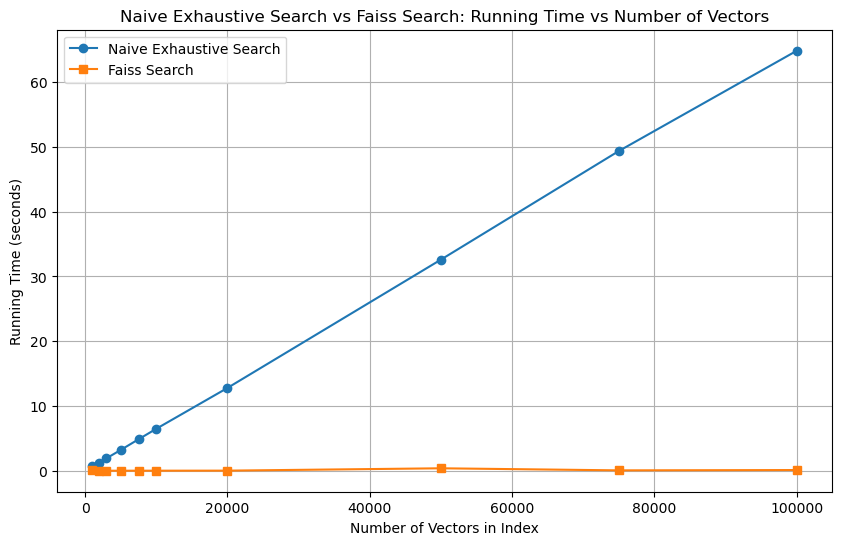

In [18]:
#TODO: Write your code for 1.1.1 here

compare_runtime_retrieval_methods(dims=100, n_queries=100, k=1, index1_search_function=naive_exhaustive_search, index2_search_function=faiss_search)

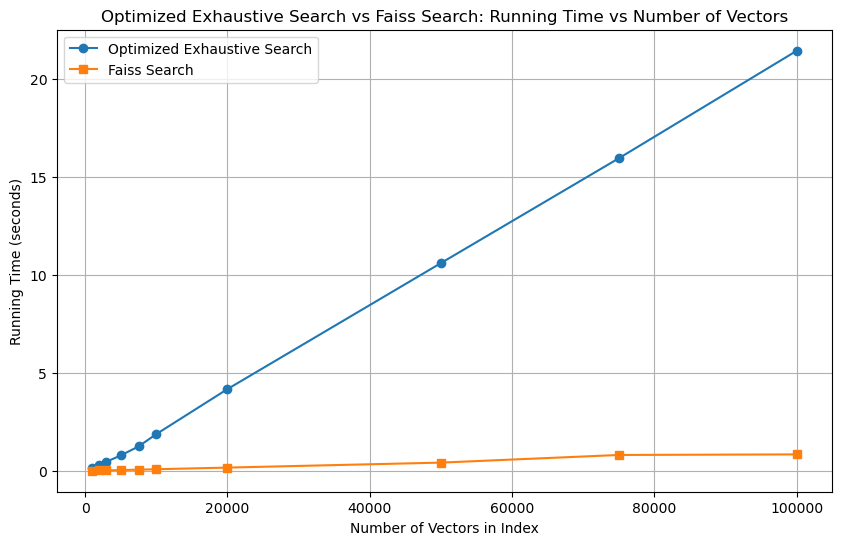

In [19]:
#TODO: Write your code for 1.1.2 here

compare_runtime_retrieval_methods(dims=500, n_queries=500, k=1, index1_search_function=optimized_exhaustive_search, index2_search_function=faiss_search)

We can see that the run time over different number of vectors in the index of the FAISS L2 search is significantly lower than a naive or optimized exhaustive search.

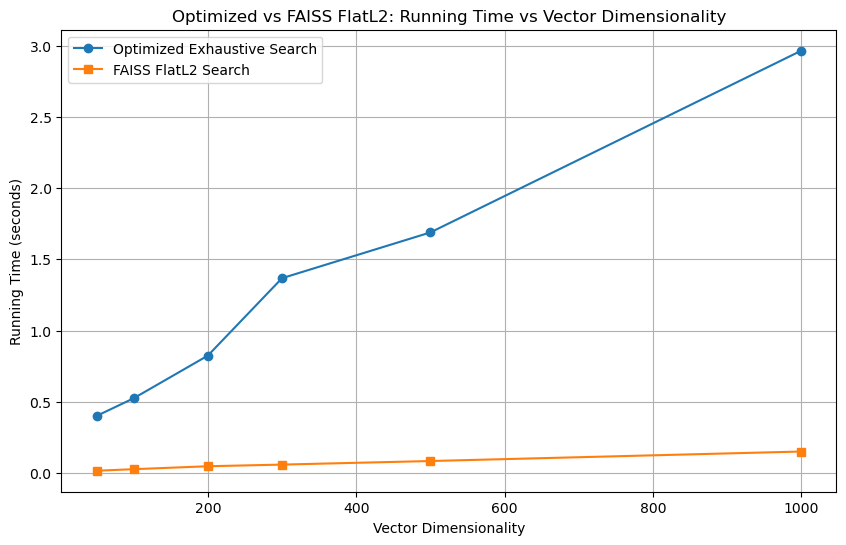

In [20]:
#TODO: Write your code for 1.1.3 here

n_index = 20000
n_queries = 200
dims_list = [50, 100, 200, 300, 500, 1000]
k = 1

optimized_times = []
faiss_times = []

for dim in dims_list:
    database = generate_vectors(n_index, dim, seed=42).astype(np.float32)
    queries = generate_vectors(n_queries, dim, seed=42).astype(np.float32)

    start = time()
    optimized_exhaustive_search(queries, database, k)
    optimized_times.append(time() - start)

    index = build_faiss_flatl2_index(database, dim)
    start = time()
    faiss_search(queries, index, k)
    faiss_times.append(time() - start)

plt.figure(figsize=(10, 6))
plt.plot(dims_list, optimized_times, marker='o', label='Optimized Exhaustive Search')
plt.plot(dims_list, faiss_times, marker='s', label='FAISS FlatL2 Search')
plt.xlabel("Vector Dimensionality")
plt.ylabel("Running Time (seconds)")
plt.title("Optimized vs FAISS FlatL2: Running Time vs Vector Dimensionality")
plt.legend()
plt.grid(True)
plt.show()

We can see that the run time over different vector dimensionality in the index of the FAISS L2 search is significantly lower than an optimized exhaustive search.

# 1.2 -- Faiss LSH
### Create the following plots:
##### 1.2.1. Running time of Faiss LSH as a function of the number of vectors in the index (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* nbits: 500

##### 1.2.2. Running time of Faiss LSH as a function of nbits (x-axis) with the following parameters fixed:
* vector dimensionality: 100
* number of vectors in the query set: 1000
* number of vectors in the index: 500000


##### 1.2.3. recall@k of Faiss LSH as a function of nbits (x-axis) with the following parameters fixed:
* vector dimensionality: 500
* number of vectors in the query set: 100
* number of vectors in the index: 100000
* k: 10


You need to complete the code so that the generated plots should reflect the desired metrics as a function of the desired parameters.
The plots should be clear and self-explanatory, including the labels, title, and legend.
There is no need to experiment with long running times (few seconds are enough for each plot); just ensure that the trends are visible.
You are allowed to add more cells before and between the TODOs, but do not flip the order of the subsections.
Make sure that when you submit the notebook, the plots are generated (namely the cell is already executed and the plots are displayed in the notebook).


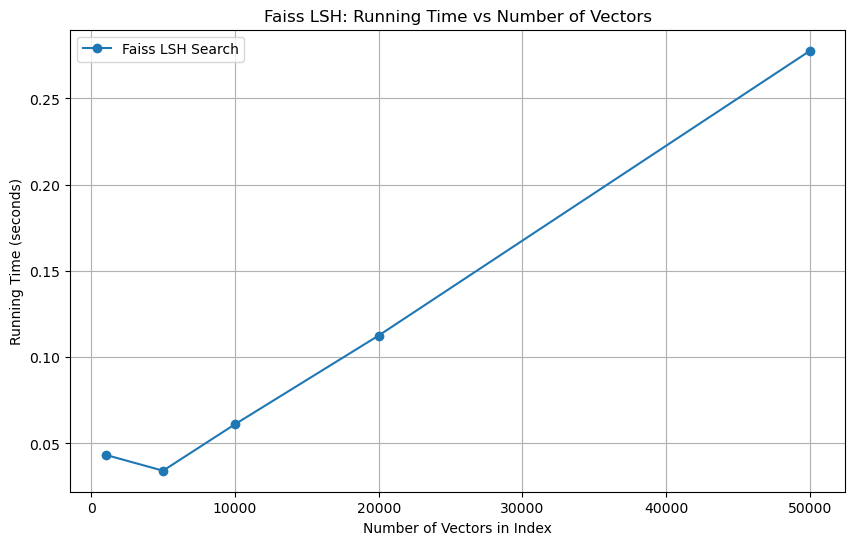

In [21]:
#TODO: Write your code for 1.2.1 here

dims = 100
n_queries = 1000
index_sizes = [1000, 5000, 10000, 20000, 50000]
nbits = 500
k = 1

lsh_times = []

queries = generate_vectors(n_queries, dims, seed=42).astype(np.float32)

for n in index_sizes:
    database = generate_vectors(n, dims, seed=42).astype(np.float32)

    index = build_faiss_lsh_index(database, dims, nbits)
    start = time()
    faiss_search(queries, index, k)
    lsh_times.append(time() - start)

plt.figure(figsize=(10, 6))
plt.plot(index_sizes, lsh_times, marker='o', label='Faiss LSH Search')
plt.xlabel("Number of Vectors in Index")
plt.ylabel("Running Time (seconds)")
plt.title("Faiss LSH: Running Time vs Number of Vectors")
plt.legend()
plt.grid(True)
plt.show()

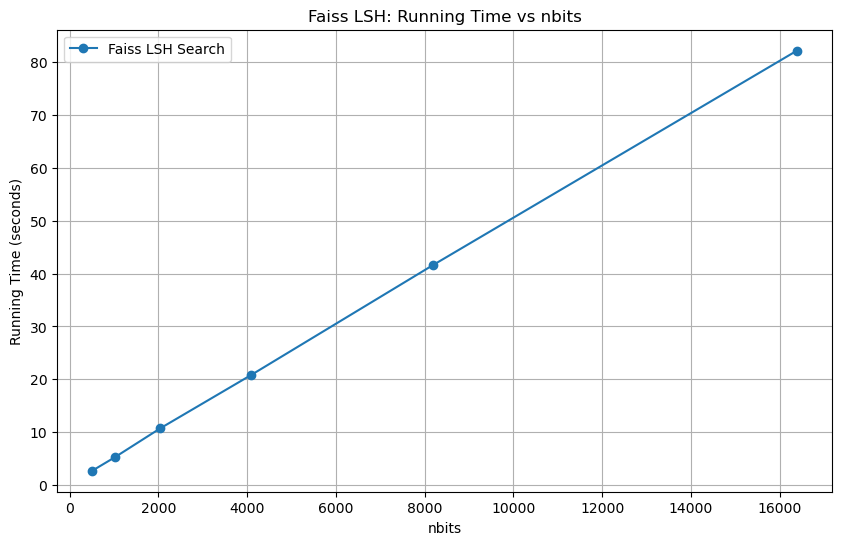

In [22]:
#TODO: Write your code for 1.2.2 here

dims = 100
n_queries = 1000
n_index = 500000
nbits_list = [512, 1024, 2048, 4096, 8192, 16384]
k = 1

database = generate_vectors(n_index, dims, seed=42).astype(np.float32)
queries = generate_vectors(n_queries, dims, seed=42).astype(np.float32)

lsh_times = []

for nbits in nbits_list:
    index = build_faiss_lsh_index(database, dims, nbits)
    start = time()
    faiss_search(queries, index, k)
    lsh_times.append(time() - start)

plt.figure(figsize=(10, 6))
plt.plot(nbits_list, lsh_times, marker='o', label='Faiss LSH Search')
plt.xlabel("nbits")
plt.ylabel("Running Time (seconds)")
plt.title("Faiss LSH: Running Time vs nbits")
plt.legend()
plt.grid(True)
plt.show()

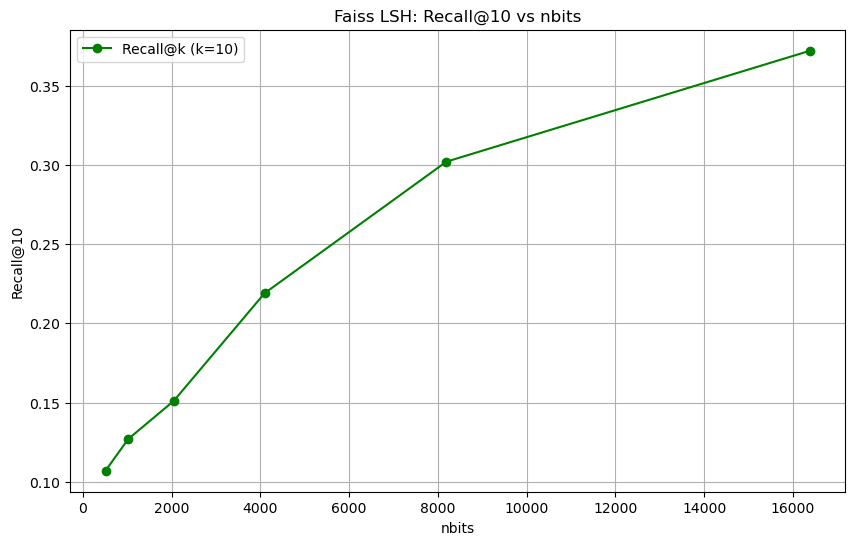

In [23]:
#TODO: Write your code for 1.2.3 here

dims = 500
n_queries = 100
n_index = 100000
nbits_list = [512, 1024, 2048, 4096, 8192, 16384]
k = 10

database = generate_vectors(n_index, dims, seed=42).astype(np.float32)
queries = generate_vectors(n_queries, dims, seed=42).astype(np.float32)

true_neighbors = optimized_exhaustive_search(queries, database, k)

recalls = []

for nbits in nbits_list:
    index = build_faiss_lsh_index(database, dims, nbits)
    approx_neighbors = faiss_search(queries, index, k)
    recall = compute_recall_at_k(true_neighbors, approx_neighbors, k)
    recalls.append(recall)

plt.figure(figsize=(10, 6))
plt.plot(nbits_list, recalls, marker='o', color='green', label='Recall@k (k=10)')
plt.xlabel("nbits")
plt.ylabel("Recall@10")
plt.title("Faiss LSH: Recall@10 vs nbits")
plt.grid(True)
plt.legend()
plt.show()

We can see that the recall increases with higher number of bits of the LSH algorithm. This is a logical inference because increasing number of bits increases the precision of the similarity between the query and the requested items.